In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '17/03/2022'
id_noticia = '280890'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'
dias_grafico = 180

In [3]:
def DrawMediaFlotante (dfData, provincia, dias):   
    data = dfData.loc[provincia].diff().tail(dias).copy()
    data['Media Positivo 7 dias'] = data['PCR Positivo'].rolling(window=7).mean()
    data['Media Positivo 14 dias'] = data['PCR Positivo'].rolling(window=14).mean()
    titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia
    # print(titulo + '. (Nuevos positivos e ingresos hospitalarios)')
    data[['Hospitalización', 'PCR Positivo', 'Media Positivo 7 dias', 'Media Positivo 14 dias']].plot(
        kind='line', grid=True, figsize=(15,5), title=titulo)
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()
    

In [4]:
def DrawMediasDiarias(dfData, provincia, variable, dias):
    data = pd.DataFrame(dfData.loc[provincia][variable].tail(dias).copy())
    data.columns = [variable]
    data['Media 7 dias'] = data[variable].rolling(window=7).mean()
    data['Media 14 dias'] = data[variable].rolling(window=14).mean()
    data['Media 28 dias'] = data[variable].rolling(window=28).mean()
    data.plot(title= variable + ' por día en ' + provincia, figsize=(15,5), grid=True, color = ['lightgrey', 'green', 'orange', 'red'])
    plt.xticks(
        rotation=45,    
        horizontalalignment='right',
        fontweight='light',
    )
    plt.show()


In [5]:
# FIX SSL: CERTIFICATE_VERIFY_FAILED with Python3
# https://stackoverflow.com/a/49174340
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [6]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[len(tables) - 1] # Last table

In [7]:
# Prepare
dfL.columns = ['Provincia', 'PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos', 'Recuperados']
dfL['Fecha'] = fecha
regex = r"(.*\d).*\(.*$"
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos']:
    dfL[col] = dfL[col].str.extract(regex, expand=False).fillna(0).apply(lambda x : str(x).replace('.', '')).astype(int)

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Recuperados,Fecha
0,Almería,134197,5551,873,1151,130.350(+269),17/03/2022
1,Cádiz,187639,7518,726,1783,180.268(+266),17/03/2022
2,Córdoba,141909,6866,780,1318,136.819(+309),17/03/2022
3,Granada,171577,11102,1232,2099,165.780(+144),17/03/2022
4,Huelva,80906,3824,268,481,76.495(+189),17/03/2022
5,Jaén,111467,6316,544,1297,107.937(+179),17/03/2022
6,Málaga,265820,13249,1121,2328,255.748(+553),17/03/2022
7,Sevilla,283898,15491,1402,2726,274.965(+345),17/03/2022
8,Total,1377413,69917,6946,13183,1.328.362(+2.254),17/03/2022


In [8]:
dfL = dfL[['Provincia', 'Fecha', 'PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']]
dfL

,Provincia,Fecha,PCR Positivo,Hospitalización,UCI,Fallecimientos
0,Almería,17/03/2022,134197,5551,873,1151
1,Cádiz,17/03/2022,187639,7518,726,1783
2,Córdoba,17/03/2022,141909,6866,780,1318
3,Granada,17/03/2022,171577,11102,1232,2099
4,Huelva,17/03/2022,80906,3824,268,481
5,Jaén,17/03/2022,111467,6316,544,1297
6,Málaga,17/03/2022,265820,13249,1121,2328
7,Sevilla,17/03/2022,283898,15491,1402,2726
8,Total,17/03/2022,1377413,69917,6946,13183


In [9]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
# data.sample(5)

In [10]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [11]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
dfL = dfL[dfL['variable'] != 'Curados'] # remove Curados from results

In [12]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [13]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [14]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').diff()
# dfV.tail()

In [15]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]
dfG

,variable,Fallecimientos,Hospitalización,PCR Positivo,UCI
Provincia,Fecha,,,,
Almería,2022-03-17,1.0,0.0,248.0,1.0
Cádiz,2022-03-17,0.0,7.0,484.0,1.0
Córdoba,2022-03-17,1.0,3.0,174.0,0.0
Granada,2022-03-17,1.0,2.0,266.0,0.0
Huelva,2022-03-17,1.0,5.0,233.0,1.0
Jaén,2022-03-17,3.0,1.0,169.0,4.0
Málaga,2022-03-17,3.0,17.0,833.0,0.0
Sevilla,2022-03-17,5.0,19.0,346.0,0.0
Total,2022-03-17,15.0,54.0,2753.0,7.0


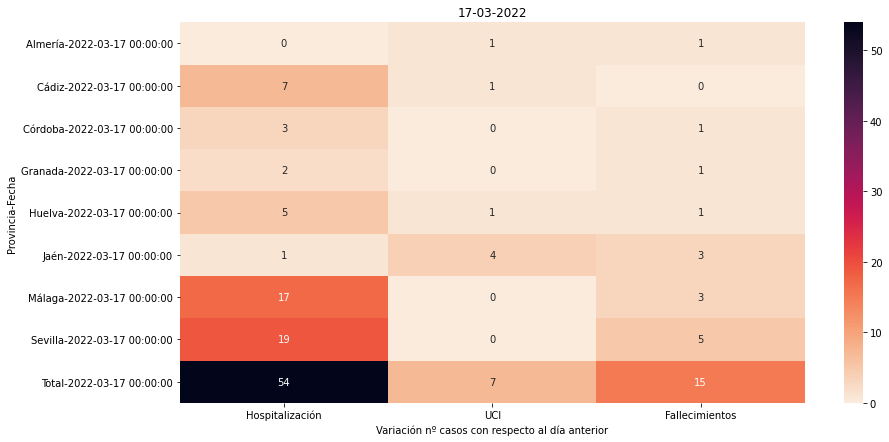

In [16]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap,fmt='g')

# Add label for horizontal axis
plt.xlabel('Variación nº casos con respecto al día anterior')
plt.show()

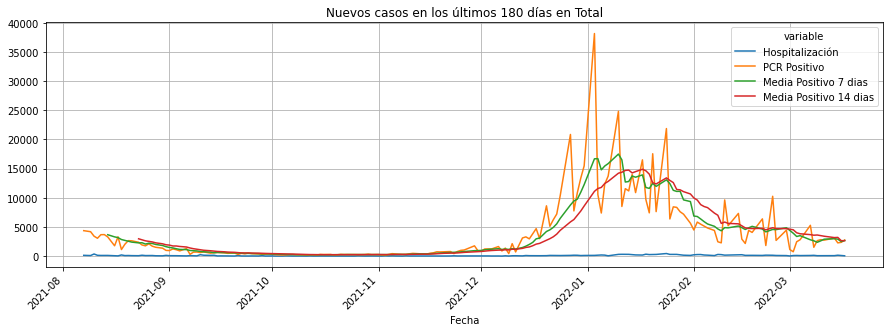

In [17]:
DrawMediaFlotante(df, 'Total', dias_grafico)

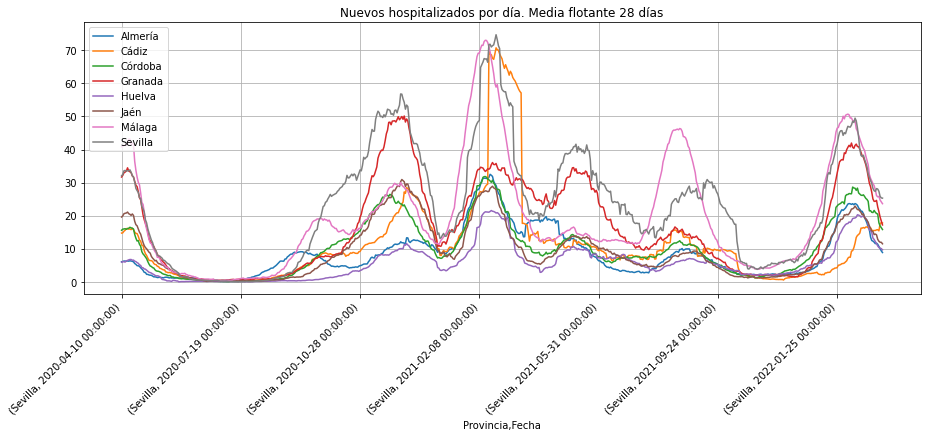

In [18]:
dias = 28
data = dfV['Hospitalización'].rolling(window=dias).mean().dropna().drop('Total')
data.groupby('Provincia').plot(title='Nuevos hospitalizados por día. Media flotante ' + str(dias) + ' días', figsize=(15,5), grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.legend(loc='upper left')
plt.show()

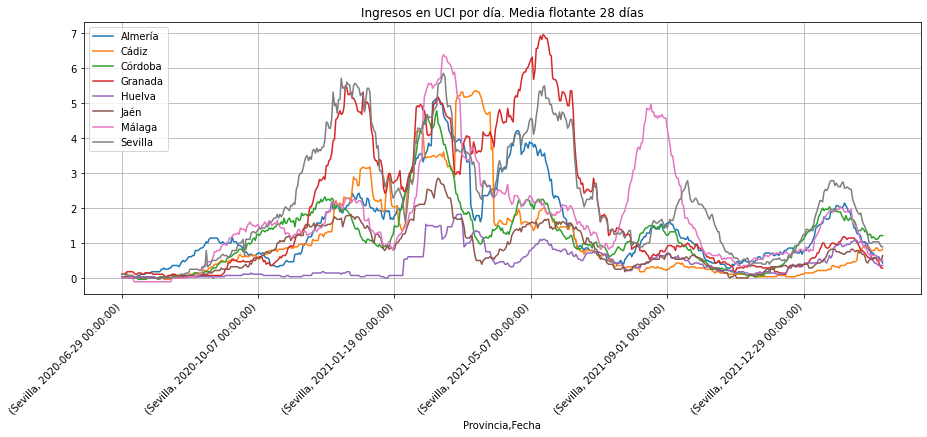

In [19]:
dias = 28
data = dfV['UCI'].rolling(window=dias).mean().dropna().drop('Total')
data.groupby('Provincia').plot(title='Ingresos en UCI por día. Media flotante ' + str(dias) + ' días', figsize=(15,5), grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.legend(loc='upper left')
plt.show()

In [20]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Hospitalización'], ascending=[False, True])

variable,Fecha,Hospitalización,dias
Provincia,,,
Almería,2022-03-16,5.0,1 days
Jaén,2022-03-17,1.0,0 days
Granada,2022-03-17,2.0,0 days
Córdoba,2022-03-17,3.0,0 days
Huelva,2022-03-17,5.0,0 days
Cádiz,2022-03-17,7.0,0 days
Málaga,2022-03-17,17.0,0 days
Sevilla,2022-03-17,19.0,0 days
Total,2022-03-17,54.0,0 days


In [21]:
# Positivos por cada Hospitalización
dfG['PCR Positivo']/dfG['Hospitalización']

Provincia  Fecha     
Almería    2022-03-17           inf
Cádiz      2022-03-17     69.142857
Córdoba    2022-03-17     58.000000
Granada    2022-03-17    133.000000
Huelva     2022-03-17     46.600000
Jaén       2022-03-17    169.000000
Málaga     2022-03-17     49.000000
Sevilla    2022-03-17     18.210526
Total      2022-03-17     50.981481
dtype: float64

In [22]:
# Media ingresos diarios en hospital últimos 28 días
dias = 28
dfV.groupby('Provincia').tail(dias)['Hospitalización'].groupby('Provincia').mean()

Provincia
Almería      8.821429
Cádiz       17.750000
Córdoba     15.785714
Granada     17.178571
Huelva       9.642857
Jaén        11.464286
Málaga      23.607143
Sevilla     25.285714
Total      129.535714
Name: Hospitalización, dtype: float64

In [23]:
# Fecha de último ingreso en UCI
data = df[['UCI']].diff()
data = data[data['UCI'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'UCI'], ascending=[False, True])

variable,Fecha,UCI,dias
Provincia,,,
Granada,2022-03-04,1.0,13 days
Córdoba,2022-03-15,2.0,2 days
Sevilla,2022-03-15,3.0,2 days
Málaga,2022-03-16,1.0,1 days
Huelva,2022-03-17,1.0,0 days
Cádiz,2022-03-17,1.0,0 days
Almería,2022-03-17,1.0,0 days
Jaén,2022-03-17,4.0,0 days
Total,2022-03-17,7.0,0 days


In [24]:
# Fecha de último Fallecimiento
data = df[['Fallecimientos']].diff()
data = data[data['Fallecimientos'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values(['dias', 'Fallecimientos'], ascending=[False, True])

variable,Fecha,Fallecimientos,dias
Provincia,,,
Cádiz,2022-03-15,1.0,2 days
Huelva,2022-03-17,1.0,0 days
Granada,2022-03-17,1.0,0 days
Córdoba,2022-03-17,1.0,0 days
Almería,2022-03-17,1.0,0 days
Málaga,2022-03-17,3.0,0 days
Jaén,2022-03-17,3.0,0 days
Sevilla,2022-03-17,5.0,0 days
Total,2022-03-17,15.0,0 days


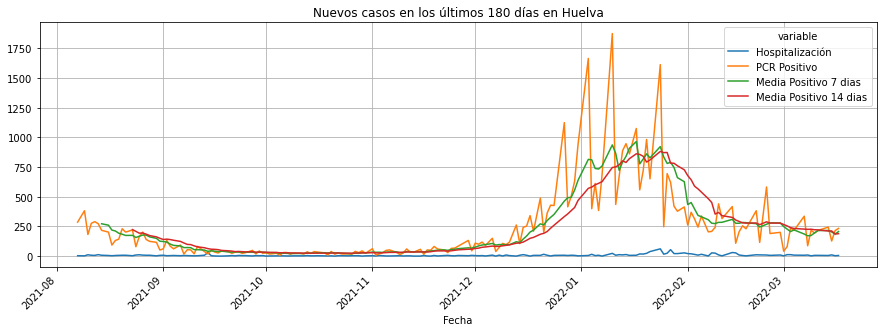

In [25]:
DrawMediaFlotante(df, 'Huelva', dias_grafico)

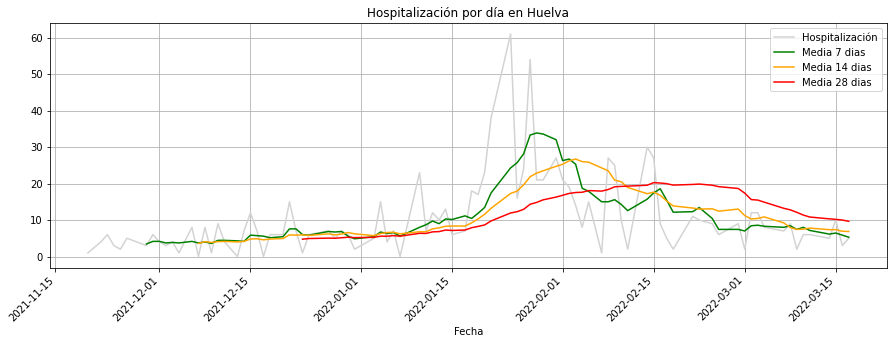

In [26]:
DrawMediasDiarias(dfV, 'Huelva', 'Hospitalización', 90)

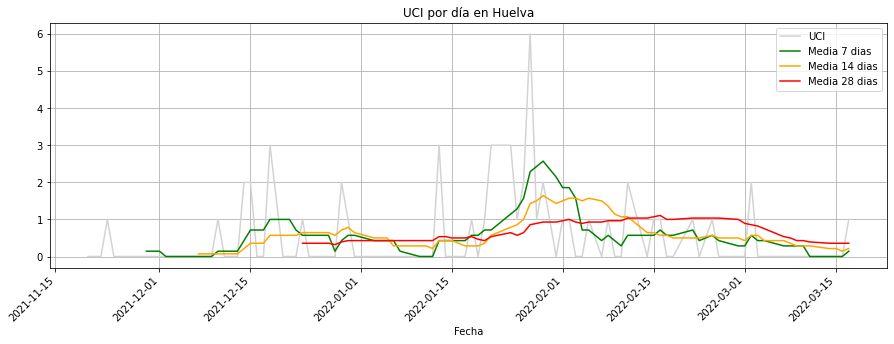

In [27]:
DrawMediasDiarias(dfV, 'Huelva', 'UCI', 90)

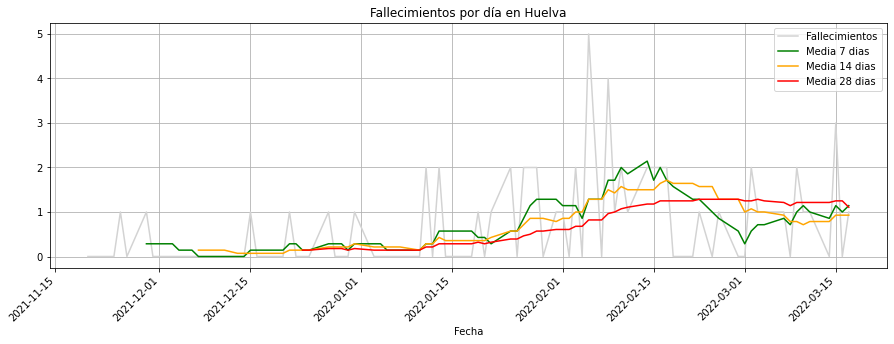

In [28]:
DrawMediasDiarias(dfV, 'Huelva', 'Fallecimientos', 90)

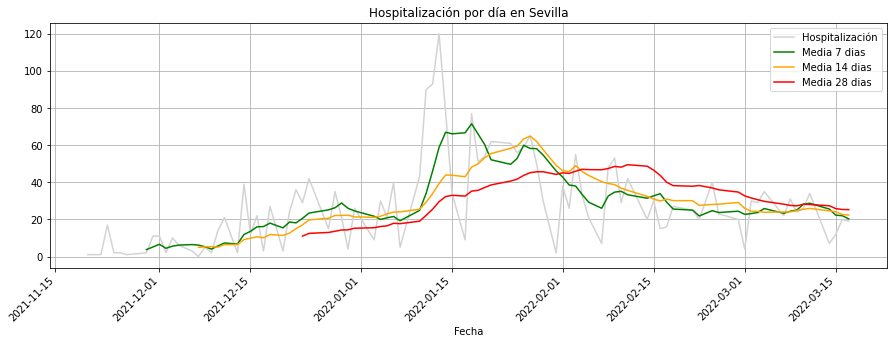

In [29]:
DrawMediasDiarias(dfV, 'Sevilla', 'Hospitalización', 90)

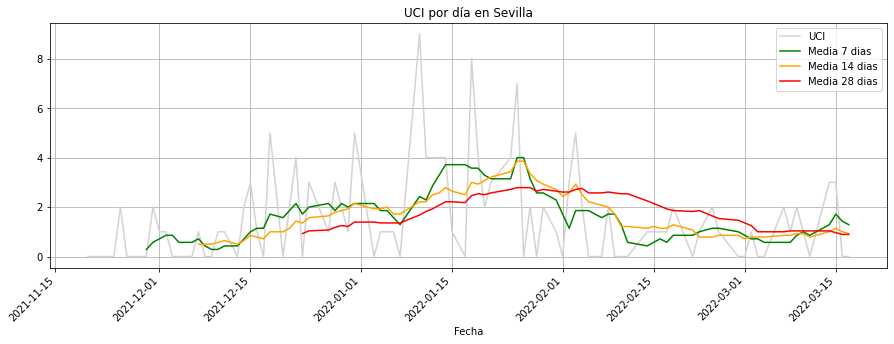

In [30]:
DrawMediasDiarias(dfV, 'Sevilla', 'UCI', 90)

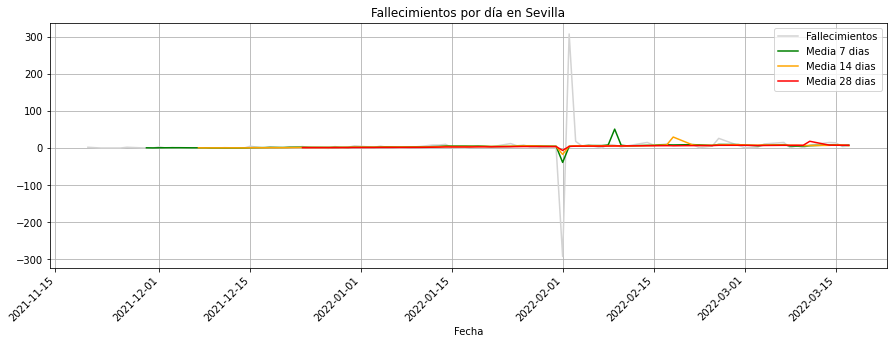

In [31]:
DrawMediasDiarias(dfV, 'Sevilla', 'Fallecimientos', 90)

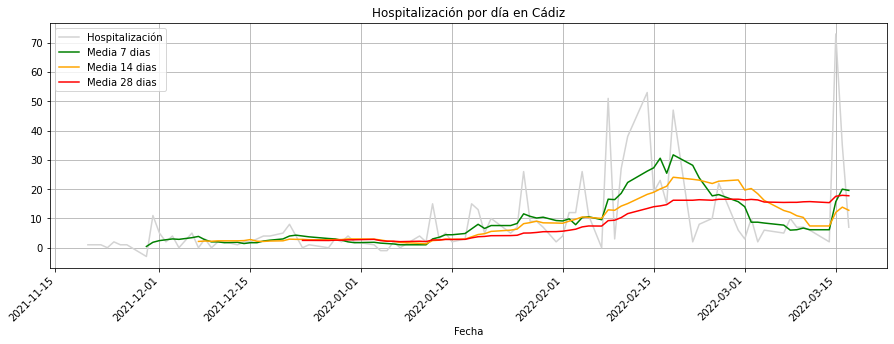

In [32]:
DrawMediasDiarias(dfV, 'Cádiz', 'Hospitalización', 90)

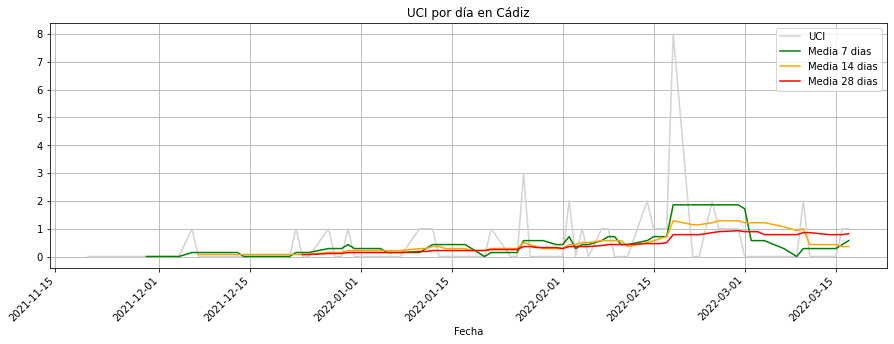

In [33]:
DrawMediasDiarias(dfV, 'Cádiz', 'UCI', 90)

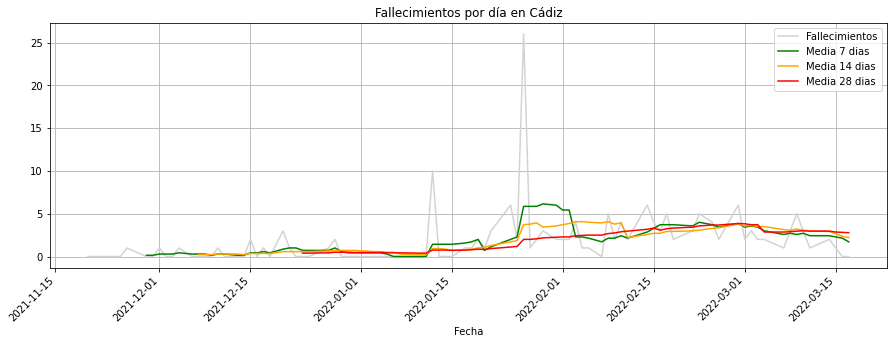

In [34]:
DrawMediasDiarias(dfV, 'Cádiz', 'Fallecimientos', 90)

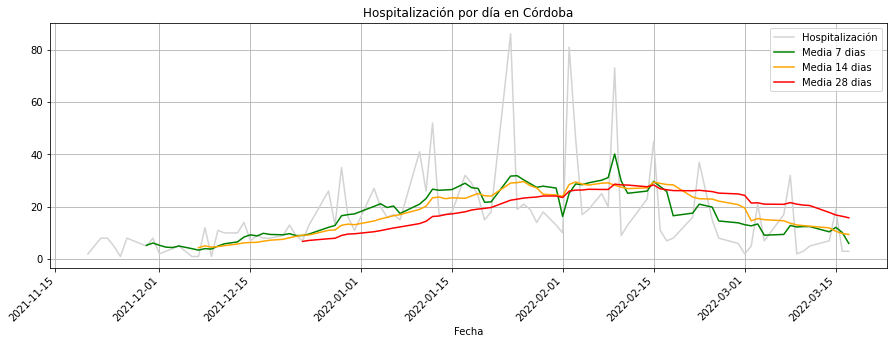

In [35]:
DrawMediasDiarias(dfV, 'Córdoba', 'Hospitalización', 90)

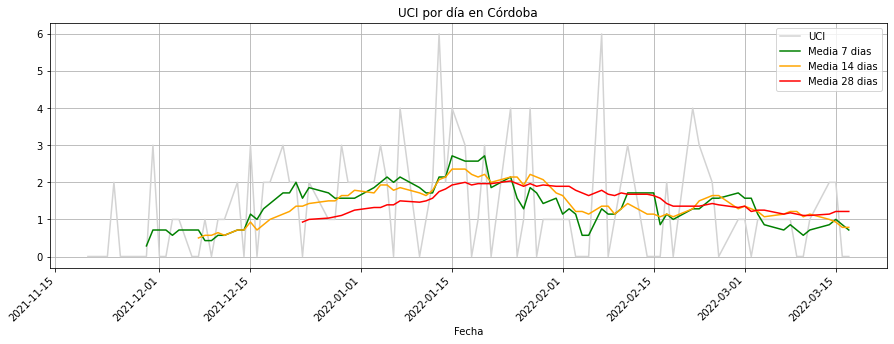

In [36]:
DrawMediasDiarias(dfV, 'Córdoba', 'UCI', 90)

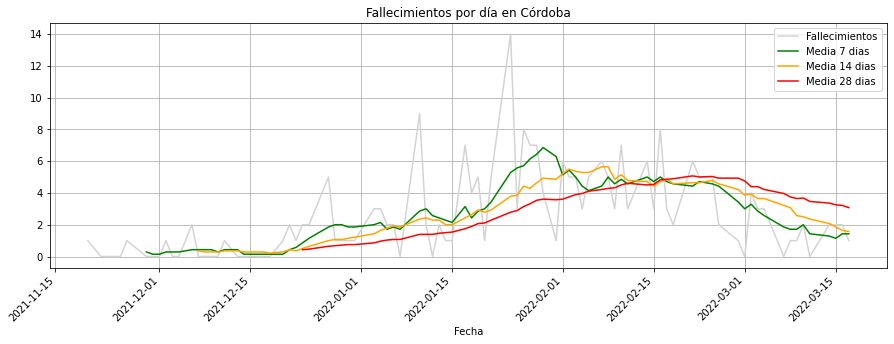

In [37]:
DrawMediasDiarias(dfV, 'Córdoba', 'Fallecimientos', 90)

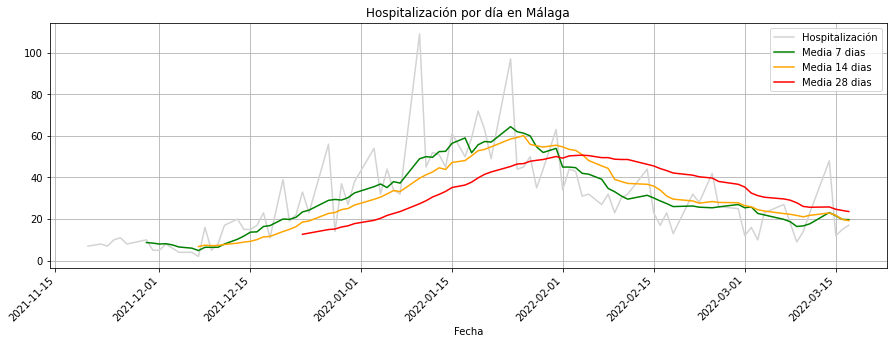

In [38]:
DrawMediasDiarias(dfV, 'Málaga', 'Hospitalización', 90)

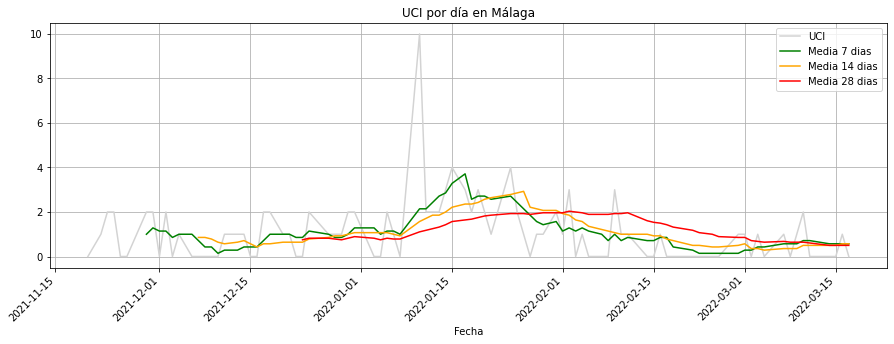

In [39]:
DrawMediasDiarias(dfV, 'Málaga', 'UCI', 90)

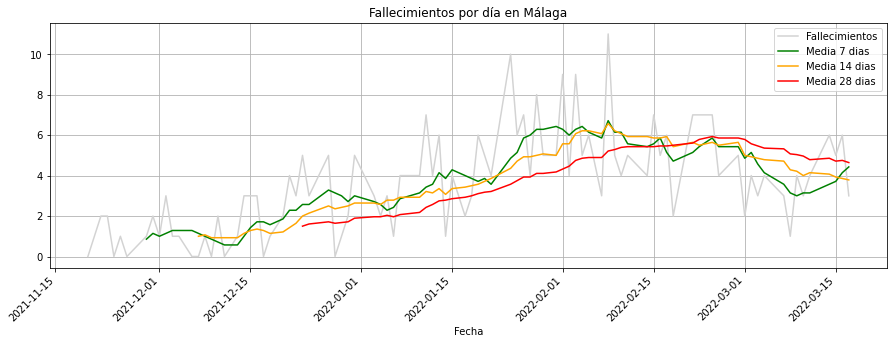

In [40]:
DrawMediasDiarias(dfV, 'Málaga', 'Fallecimientos', 90)

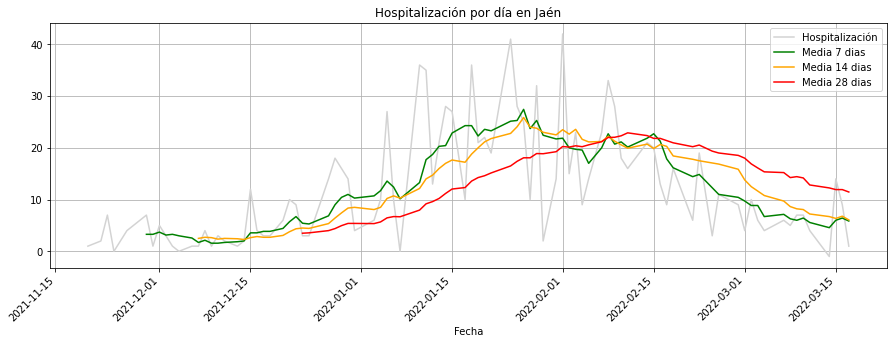

In [41]:
DrawMediasDiarias(dfV, 'Jaén', 'Hospitalización', 90)

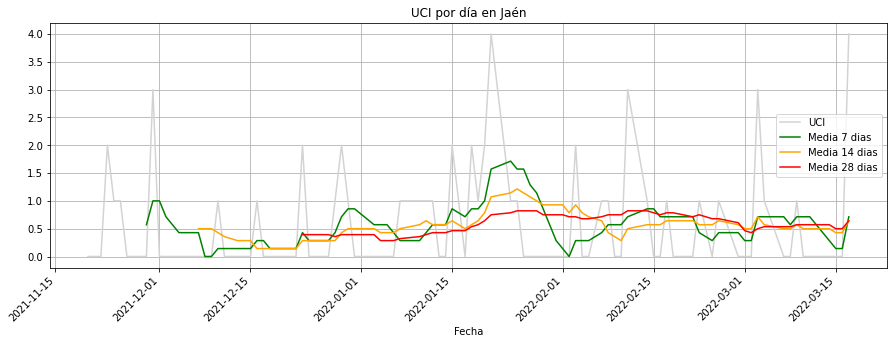

In [42]:
DrawMediasDiarias(dfV, 'Jaén', 'UCI',90)

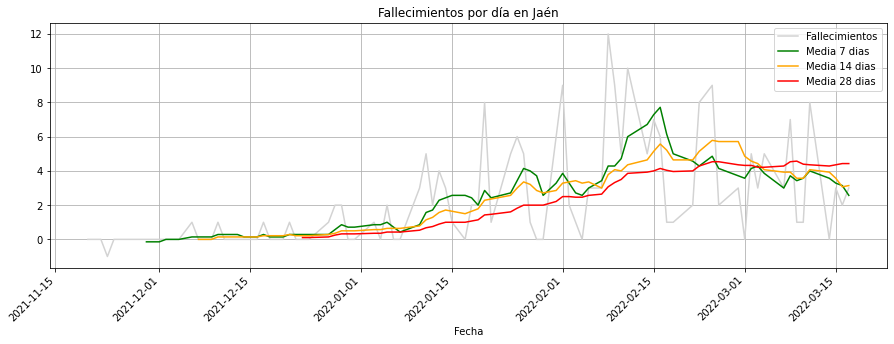

In [43]:
DrawMediasDiarias(dfV, 'Jaén', 'Fallecimientos', 90)

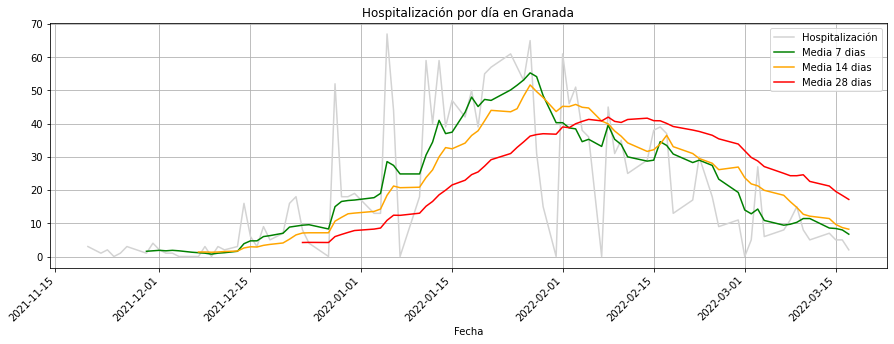

In [44]:
DrawMediasDiarias(dfV, 'Granada', 'Hospitalización', 90)

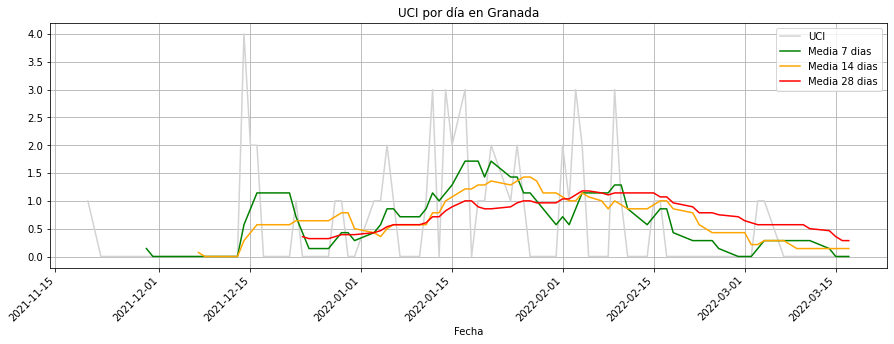

In [45]:
DrawMediasDiarias(dfV, 'Granada', 'UCI', 90)

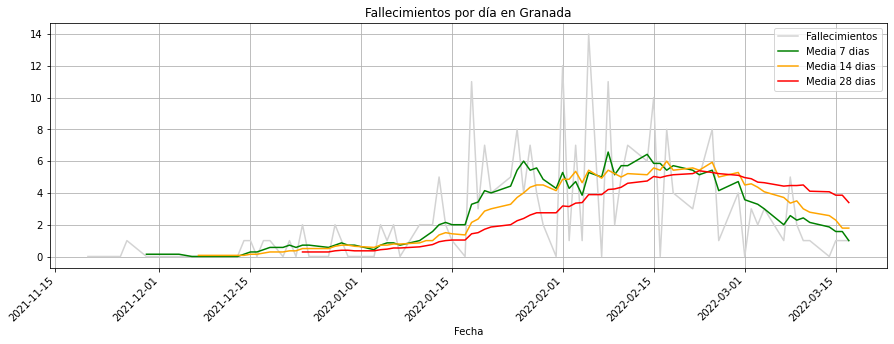

In [46]:
DrawMediasDiarias(dfV, 'Granada', 'Fallecimientos', 90)

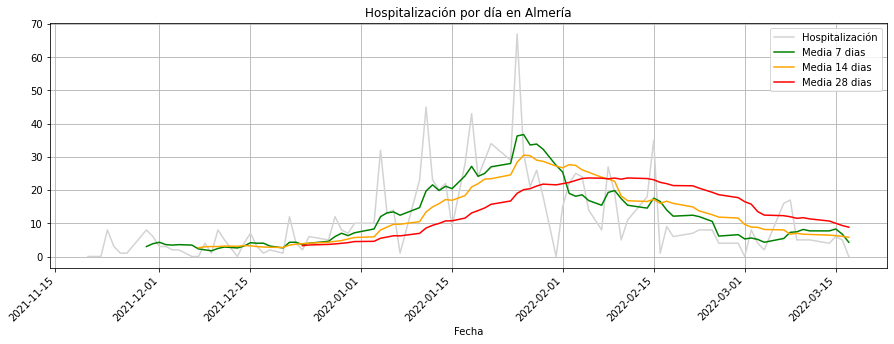

In [47]:
DrawMediasDiarias(dfV, 'Almería', 'Hospitalización', 90)

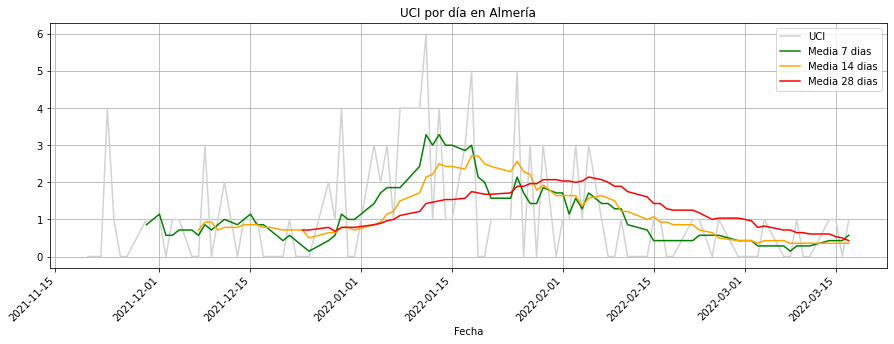

In [48]:
DrawMediasDiarias(dfV, 'Almería', 'UCI', 90)

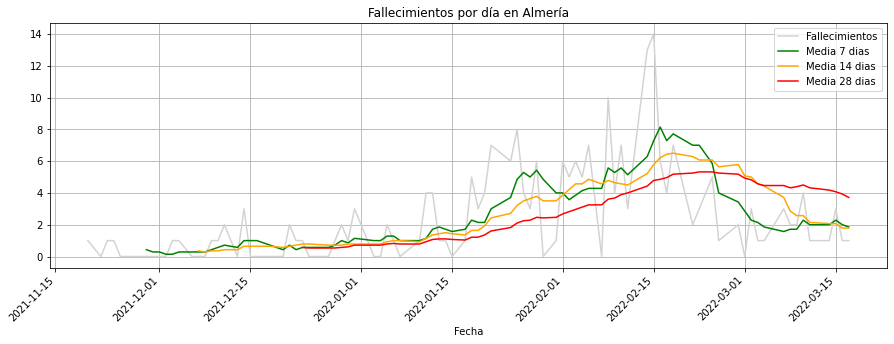

In [49]:
DrawMediasDiarias(dfV, 'Almería', 'Fallecimientos', 90)